In [2]:
%matplotlib inline

<!-- omit in toc -->
# questions

* programme python qui prend une image array en entrée ?  
  terminal script.py + argument par ex l'image  
  $ python script.py --file pah_to_image.png  
  argparse librairie (pré installée)  
* pytorch ou tensorflow ?
* Doit on installer kera (requirements) ou juste tensorflow ?

<!-- omit in toc -->
# Classez des images à l'aide d'algorithmes de Deep Learning

<!-- omit in toc -->
# sommaire

- [1. Problématique](#1-problématique)
- [2. Cleaning](#2-cleaning)
- [3. Exploration](#3-exploration)
- [4. feature engineering](#4-feature-engineering)

# 1. Problématique

Obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.

C'est un exercice de classification supervisée dans le domaine de la computer vision.

**Processus**

1. mettre en œuvre deux approches s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutif) à comparer en termes de temps de traitement et de résultat
   1. Une première en réalisant votre propre réseau CNN, en vous inspirant de réseaux CNN existants. Prenez soin d'optimiser certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)
   2. Une deuxième en utilisant le transfer learning, c’est-à-dire en utilisant un réseau déjà entraîné, et en le modifiant pour répondre à votre problème.


transfer learning

obligatoire : réentraîner les dernières couches pour prédire les classes qui vous intéressent seulement.  
Il est également possible d’adapter la structure (supprimer certaines couches, par exemple) ou de réentraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

Ressources de calcul

Limitez le jeu de données, en ne sélectionnant que quelques classes (races de chiens), ce qui permettra déjà de tester la démarche et la conception des modèles, avant une éventuelle généralisation.  

Maitriser le preprocesing + CNN (structure, pbtique optimisation diff hyperprmptr)

comparer CNN  et transfer learning 

accuracy score bpour évaluer ?
mesurer l'apport du preprocessing dans les resultats du modèle


mettre en oeuvre techniques de data augmentation
   algo gourmand en donnée pour
   à partir d'une image en créer plusieurs copies avec transformations pour que le modèle en connaisse plsueiurs formes 

   dans keras image.datagenerator

   20000 fichiers 120 races
   160 photos/race

Simulations pour opti le modèle (layers, etc)
Limiter le nb de classes pour réduire tps de traitement

sélectionner un modèle DL adapté
Champ d'application de classification
Au moins 2 modèles CNN 
au moins un modèle CNN transfer learning tel que VGG16, ResNet50, ou Inception ResNetV2

séparation train, test (mais sans sklearn ?)

kernel size, drop out, methode activation layer final
Expliquer au fur et à mesure ce qui est utilisé

adapter
optimizer, loss, sgd adam
batch size, nb d'epochs

résultats comparés de manière auto

transformation des variables
cropping, whitening, equalizer, débruitage, redimentionnement, miroring

montrer un exmple avant/après pour un des traitements

# 2. Cleaning/Exploration

In [1]:
# Generic librairies
import numpy as np
import pandas as pd
import os
import random
import xml.etree.ElementTree as ET

# images librairies
import cv2 # OpenCV
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
# import seaborn as sns


# # Activate multi output
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# # For jupyter NB users 
# # set size of window
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

Notre jeu de donnée est le Stanford Dogs Dataset.  
Il est téléchargeable à cette adresse : http://vision.stanford.edu/aditya86/ImageNetDogs/

Il est constitué de photos de chiens qui sont classées par race.  
Il existe un sous dossier par race.

Etudions la quantité de données disponible :

In [3]:
ini_img_dir = "../data/images/"

breed_list = os.listdir(ini_img_dir)
nb_breed = len(breed_list)

n_tot_img = 0
img_per_breed = []
for breed in breed_list:
    nb_img = len(os.listdir(ini_img_dir + breed))
    n_tot_img += len(os.listdir(ini_img_dir + breed))
    img_per_breed.append(nb_img)
    
print("Nous avons {} races et {} images.\nCela fait {} images/race en moyenne".format(nb_breed, n_tot_img, n_tot_img/nb_breed))

Nous avons 120 races et 20580 images.
Cela fait 171.5 images/race en moyenne


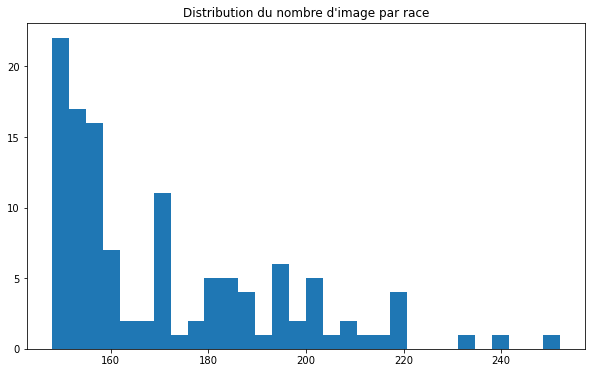

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(img_per_breed, bins=30)
plt.title('Distribution du nombre d\'image par race')
plt.savefig('../img/distri_img.png')
plt.show()

In [17]:
min(img_per_breed)

148

In [26]:
def show_images_sample(nb_breed_to_show):
    '''show 4 firsts images of nb_breed_to_show breed choosen randomly'''

    nb_breed_to_show = int(nb_breed_to_show)
    plt.figure(figsize=(16,nb_breed_to_show*4))

    # fig.suptitle(breed, fontsize=20)
    for i in range(nb_breed_to_show):
        breed = random.choice(breed_list)
        img_dir = ini_img_dir + breed
        images = os.listdir(img_dir)[:4] # select 4 first images names

        for image_nb in range(4):
            plt.subplot(nb_breed_to_show, 4, (image_nb+1)+4*(i))
            img = mpimg.imread(img_dir + '/' + images[image_nb])
            plt.imshow(img)
            if image_nb == 0:
                plt.title(breed)
            plt.axis('off')

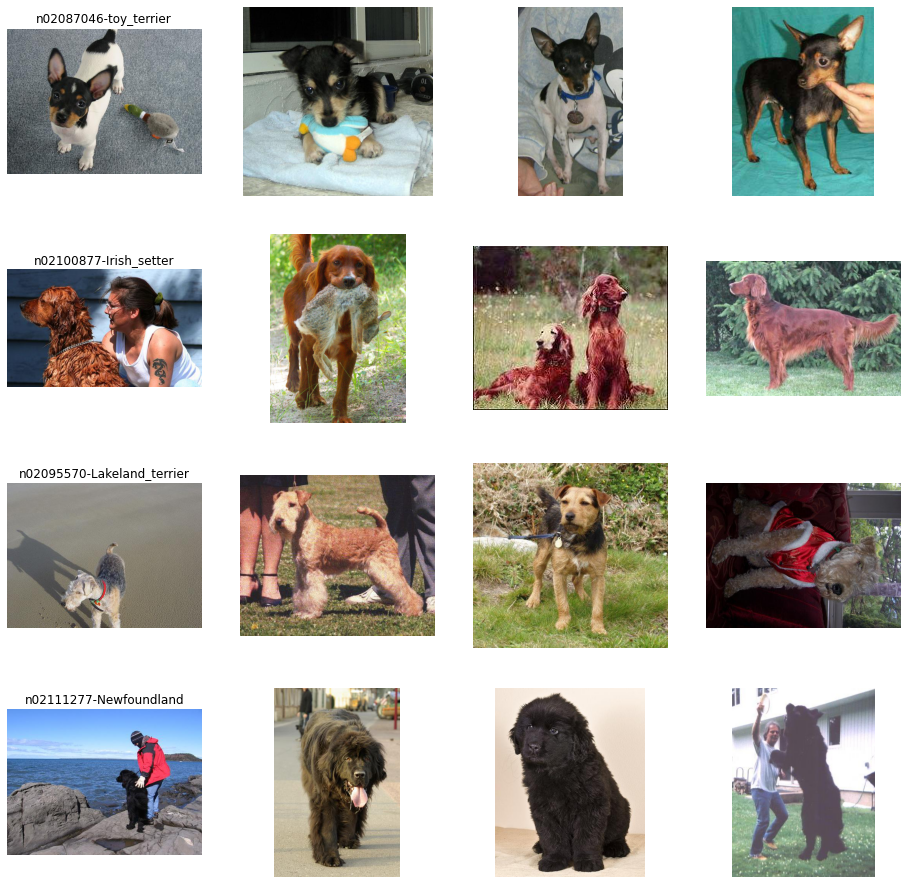

In [30]:
show_images_sample(4)

In [47]:
def resize(ini_img_dir, resized_img_dir, bnd_box_annotation_dir=None):
    '''resize images to 224x224px
    if bnd_box_annotation_dir != None it will select the proper box and then crop the image
    ini_img_dir and bnd_box_annotation_dir must have the same subdirectories and files names (except for file extension)
    '''
    if not os.path.isdir(resized_img_dir):
        os.mkdir(resized_img_dir)

    breed_list = os.listdir(ini_img_dir)

    for breed in breed_list:
        os.mkdir(resized_img_dir + breed)
        # list of img names without extention as we could use this name for annotations whose are without it.
        breed_file_list = [os.path.splitext(filename)[0] for filename in os.listdir(ini_img_dir + '{}'.format(breed))]

        for file in breed_file_list:
            img = Image.open(ini_img_dir + '{}/{}.jpg'.format(breed, file))
            # select only the bound box
            if bnd_box_annotation_dir!=None:
                tree = ET.parse(bnd_box_annotation_dir + '{}/{}'.format(breed, file))
                xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
                xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
                ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
                ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
                img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((224, 224))
            img.save(resized_img_dir + '{}/{}.jpg'.format(breed, file))

    print('Created {} folders to store cropped images of the different breeds.'.format(len(breed_list)))

In [50]:
ini_img_dir = '../data/images/'
resized_img_dir = '../data/images_resized/'
bnd_box_annotation_dir = '../data/annotation/'

# resize(ini_img_dir, resize_img_dir, bnd_box_annotation_dir)
resize(ini_img_dir, resized_img_dir)

In [53]:
from tensorflow.keras.utils import to_categorical

In [54]:

breed_list = os.listdir(resized_img_dir)

label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

def paths_and_labels(img_dir):
    '''Create lists with respectivly paths, labels, and label number of files'''

    paths = list()
    labels = list()
    targets = list()

    for breed in breed_list:
        breed_dir = img_dir +'{}/'.format(breed)
        breed_img_list = os.listdir(breed_dir)

        for img_name in breed_img_list:
            paths.append(breed_dir + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels(resized_img_dir)

assert len(paths) == len(labels)
assert len(paths) == len(targets)

# kind of one hot encoder
targets = to_categorical(targets, num_classes=num_classes)

In [58]:
from keras.preprocessing.image import ImageDataGenerator


In [64]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# epochs = 100
batch_size = 100
testsplit = .2
targetx = 224
targety = 224
# learning_rate = 0.0001
# classes = 120
seed = 42


datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        resized_img_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow_from_directory(
        resized_img_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


# 3. Preprocessing
## 3.1 whitening
## 3.2 data augmentation (mirroring, cropping...)
## 3.3 equalization
## 3.4 Cropping

# 4. CNN spécifique
# 5. Transfert learning
## 5.1 VGG16
# 6. Application
# 7. Conclusion et résultats